In [1]:
import os
import pandas as pd

def load_parquet_files(directory):
    """
    Loads all Parquet files from a specified directory into a dictionary of DataFrames.
    """
    dataframes = {}
    if not os.path.exists(directory):
        print(f"Directory not found: {directory}")
        return dataframes

    for filename in os.listdir(directory):
        if filename.endswith('.parquet'):
            file_path = os.path.join(directory, filename)
            try:
                df = pd.read_parquet(file_path)
                dataframes[os.path.splitext(filename)[0]] = df
                print(f"Loaded {filename}")
            except Exception as e:
                print(f"Failed to load {filename}: {e}")
    
    return dataframes

# Standardized data prior to running analysis
stndz_dir = os.path.join(os.getcwd(), '..', 'data', 'processed')

# Load Parquet files into dataframes dictionary
dataframes = load_parquet_files(stndz_dir)


Loaded demographics.parquet
Loaded facilities.parquet
Loaded claims.parquet


In [4]:
# List out column names
for df_name, df in dataframes.items():
    print(f"Column names in {df_name}:")
    for column in df.columns:
        print(f" - {column}")
    print()


Column names in demographics:
 - npi
 - provider_name
 - type
 - specialty
 - subspecialty
 - phone
 - address
 - address_line2
 - city
 - state
 - zip
 - provider_credentials

Column names in facilities:
 - enrollment_id
 - enrollment_state
 - provider_type_code
 - provider_type_text
 - npi
 - mulitple_npi
 - ccn
 - associate_id
 - organization_name
 - doing_business_as_name
 - incorporate_date
 - incorporate_state
 - organization_type_structure
 - organization_other_type_text
 - proprietarynonprofit_flag
 - addressline1
 - addressline2
 - city
 - state
 - zip_code
 - practice_location_type
 - location_other_type_text
 - subgroup_general_flag
 - subgroup_acute_care_flag
 - subgroup_alcohol_drug_flag
 - subgroup_children_hospital_flag
 - subgroup_longterm_flag
 - subgroup_psychiatric_flag
 - subgroup_rehabilitation_flag
 - subgroup_shortterm_flag
 - subgroup_swingbed_approved_flag
 - subgroup_psychiatric_unit_flag
 - subgroup_rehabilitation_unit_flag
 - subgroup_speciality_hospital_fla

In [8]:
# Merge claims, demographics and filter on 
#   Internal Medicine
#   Urology
#   Anesthesiology

claims = dataframes['claims']
demographics = dataframes['demographics']

# Join
joined_df = pd.merge(claims, demographics, left_on='clinician_npi', right_on='npi')

# Filter
specialties = ['INTERNAL MEDICINE', 'UROLOGY', 'ANESTHESIOLOGY']
filtered_df = joined_df[joined_df['specialty'].isin(specialties)] # no subspecialties in above categories

print(filtered_df.head())

   clinician_npi  facility_npi                   healthcare_organization_name  \
0     1942213277    1194763045                              LUTHERAN HOSPITAL   
1     1942213277    1215989611                              FAIRVIEW HOSPITAL   
2     1942213277    1710951801              ST VINCENT CHARITY MEDICAL CENTER   
3     1942213277    1679525919                THE CLEVELAND CLINIC FOUNDATION   
4     1942213277    1043397292  UNIVERSITY HOSPITALS CLEVELAND MEDICAL CENTER   

                         class  year  quarter  total_claims  total_patients  \
0  GENERAL ACUTE CARE HOSPITAL  2022        1             6               6   
1  GENERAL ACUTE CARE HOSPITAL  2022        1            86              69   
2  GENERAL ACUTE CARE HOSPITAL  2022        1             0               0   
3  GENERAL ACUTE CARE HOSPITAL  2022        1             0               0   
4  GENERAL ACUTE CARE HOSPITAL  2022        2             0               0   

                claim_counts_id       

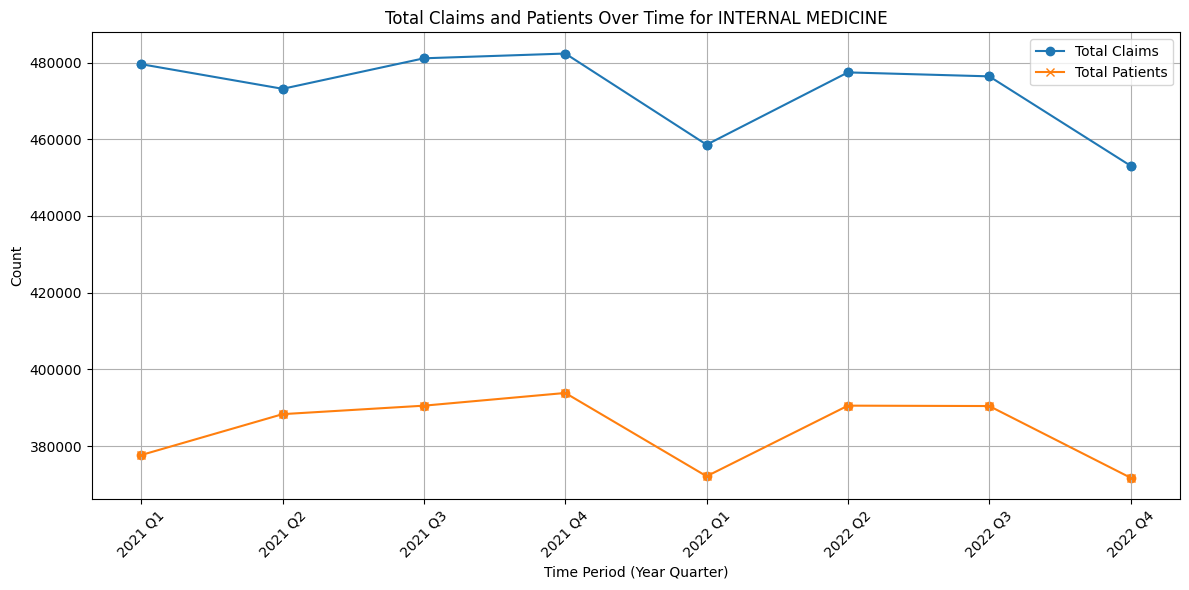

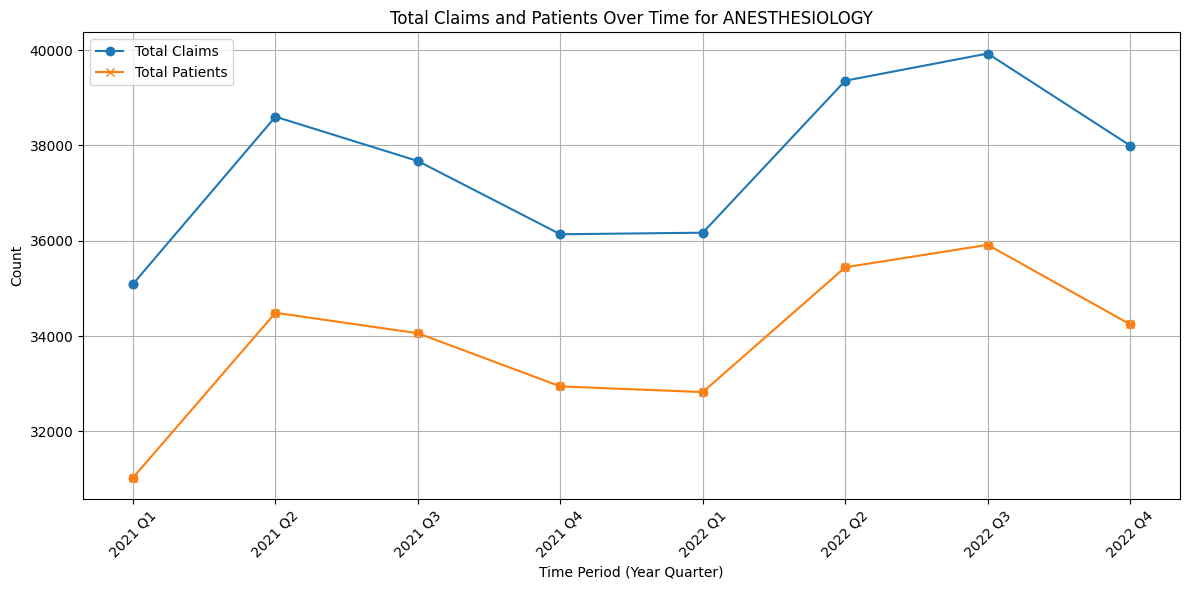

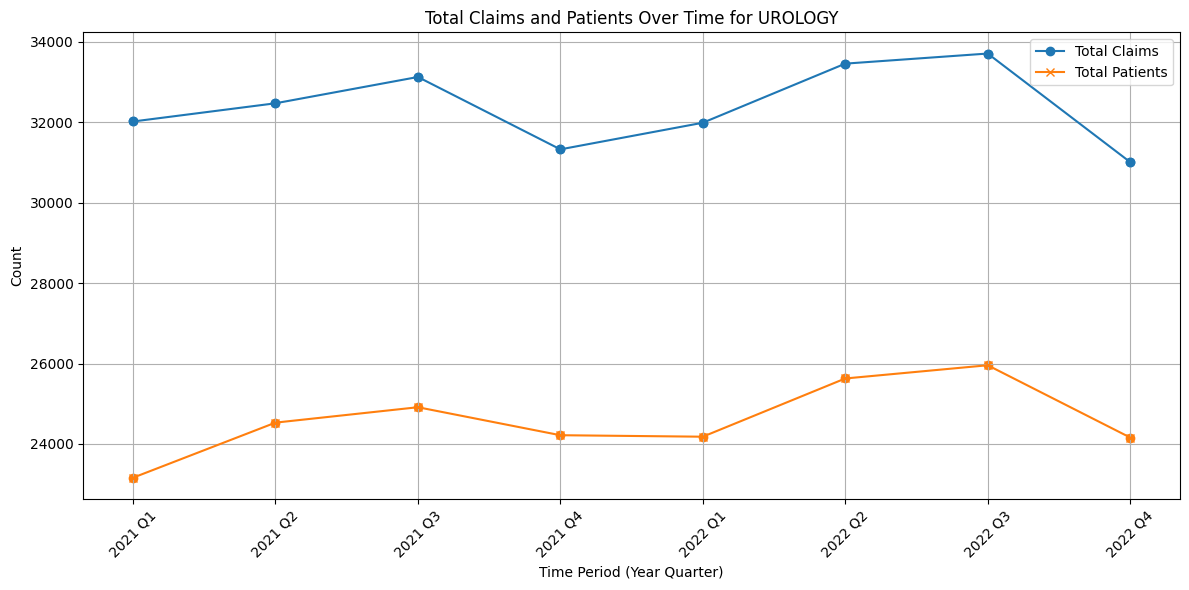

In [15]:
# Change in total claims and patients for Internal Medicine, Urology, and Anesthesiology
import matplotlib.pyplot as plt
import pandas as pd

# Create a plot for each specialty
for specialty in filtered_df['specialty'].unique():
    df_specialty = filtered_df[filtered_df['specialty'] == specialty]

    # Group by year and quarter and aggregate
    grouped_df = df_specialty.groupby(['year', 'quarter']).agg(
        total_claims_sum=pd.NamedAgg(column='total_claims', aggfunc='sum'),
        total_patients_sum=pd.NamedAgg(column='total_patients', aggfunc='sum')
    ).reset_index()

    # Creating a new column 'period' for the time period (e.g., '2021 Q1')
    grouped_df['period'] = grouped_df['year'].astype(str) + ' Q' + grouped_df['quarter'].astype(str)

    # Plot
    plt.figure(figsize=(12, 6))

    plt.plot(grouped_df['period'], grouped_df['total_claims_sum'], marker='o', label='Total Claims', linestyle='-')
    plt.scatter(grouped_df['period'], grouped_df['total_claims_sum'])

    plt.plot(grouped_df['period'], grouped_df['total_patients_sum'], marker='x', label='Total Patients', linestyle='-')
    plt.scatter(grouped_df['period'], grouped_df['total_patients_sum'])

    plt.xlabel('Time Period (Year Quarter)')
    plt.ylabel('Count')
    plt.title(f'Total Claims and Patients Over Time for {specialty}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.show()

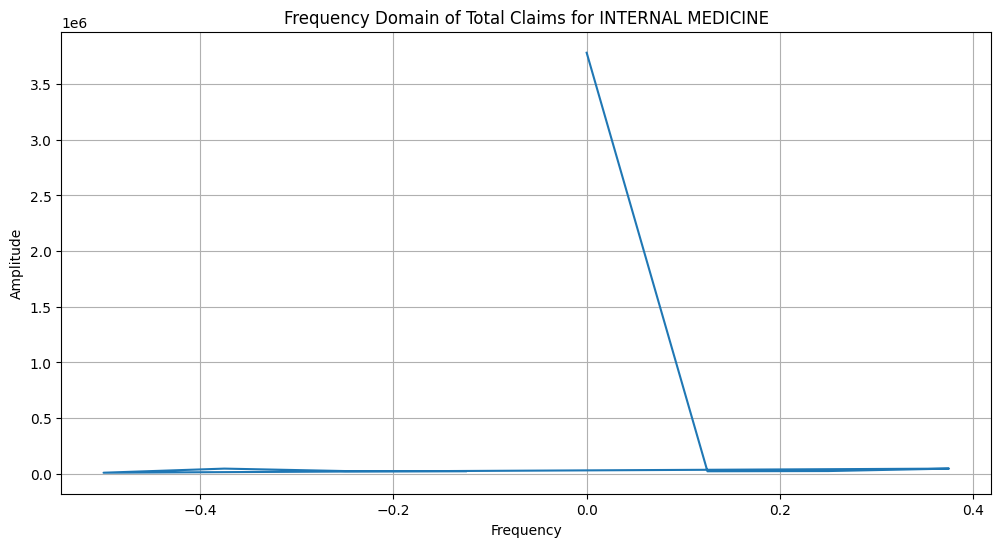

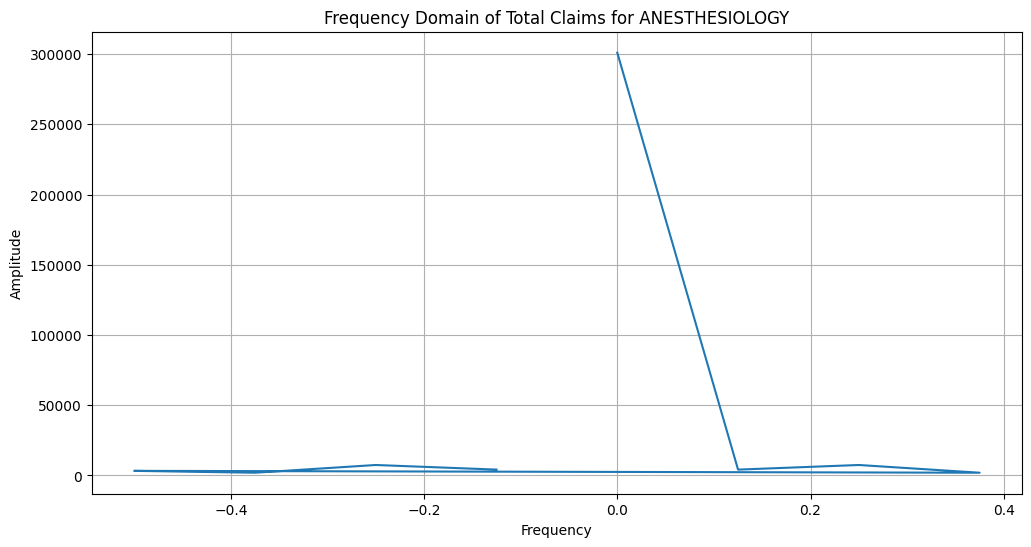

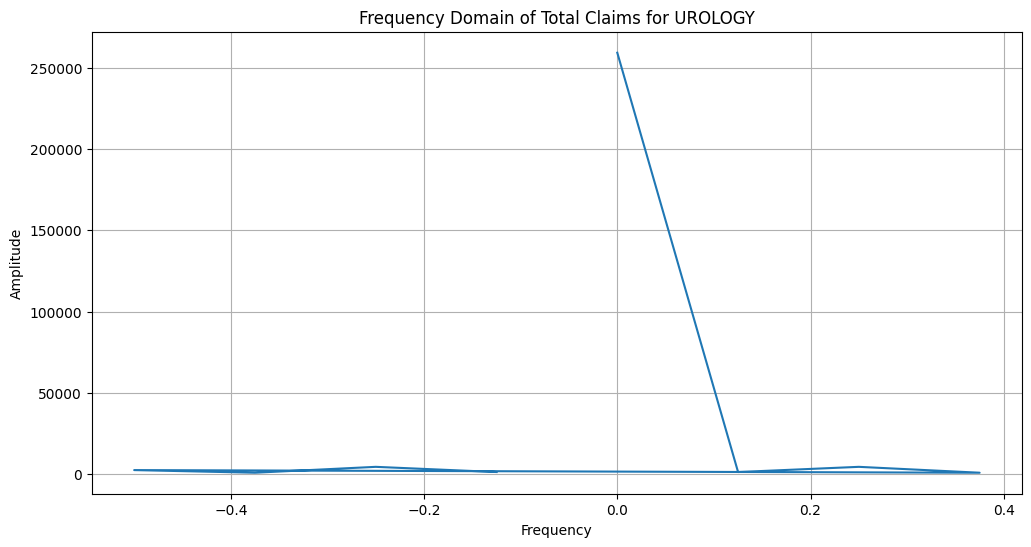

In [18]:
# data looks periodic
import numpy as np

# Perform FFT for each specialty
for specialty in filtered_df['specialty'].unique():
    df_specialty = filtered_df[filtered_df['specialty'] == specialty]

    # Group and aggregate
    grouped_df = df_specialty.groupby(['year', 'quarter'])['total_claims'].sum().reset_index()
    total_claims = grouped_df['total_claims'].to_numpy()

    # Apply Fast Fourier Transform
    fft_result = np.fft.fft(total_claims)
    frequencies = np.fft.fftfreq(len(total_claims))

    # Plot each Spectrum
    plt.figure(figsize=(12, 6))
    plt.plot(frequencies, np.abs(fft_result))
    plt.title(f'Frequency Domain of Total Claims for {specialty}')
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()


Based on this plot alone and without other significant peaks, I can't ***explicitly*** confirm periodic behavior in the claims data for these specialties. 

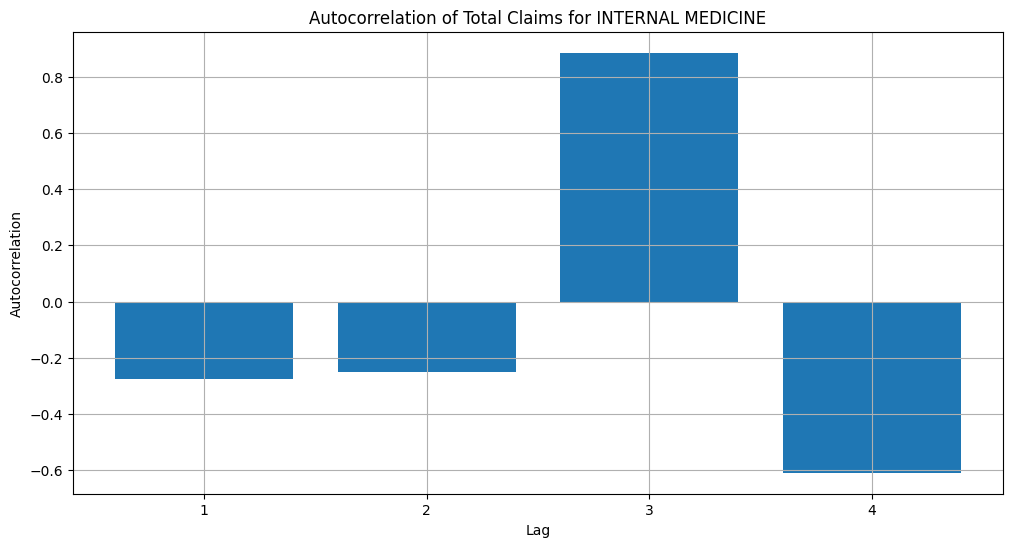

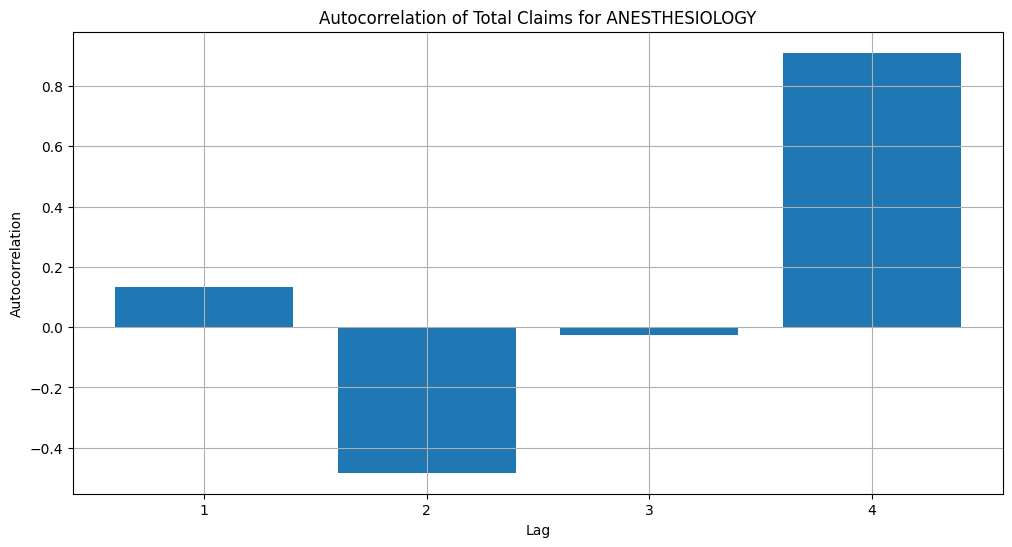

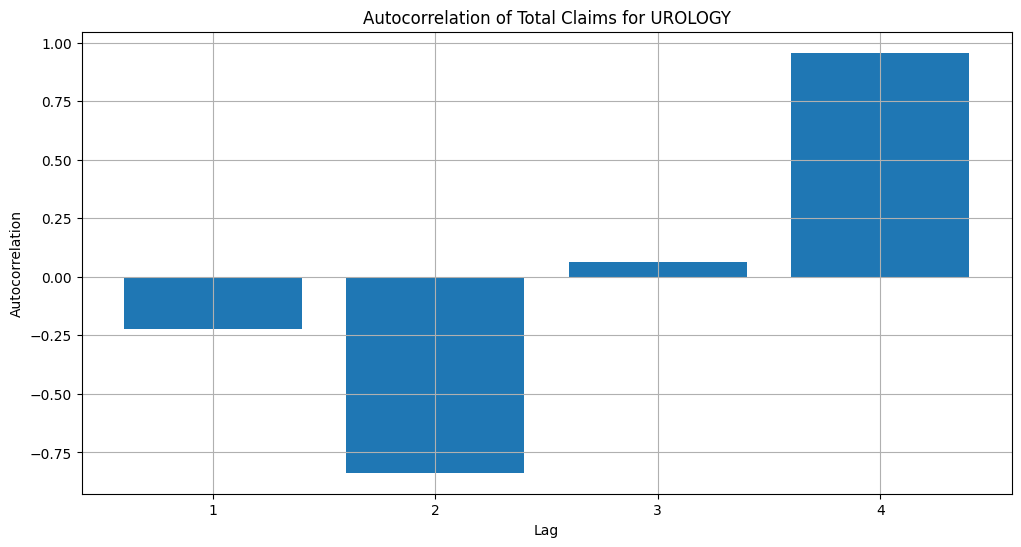

In [22]:
# Trying autocorrelation

for specialty in filtered_df['specialty'].unique():
    df_specialty = filtered_df[filtered_df['specialty'] == specialty]

    # Group and aggregate
    grouped_df = df_specialty.groupby(['year', 'quarter'])['total_claims'].sum()

    # 4 lags for the four quarters of a year
    lags = 4
    autocorrelations = [grouped_df.autocorr(lag=i) for i in range(1, lags + 1)]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.bar(range(1, lags + 1), autocorrelations)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title(f'Autocorrelation of Total Claims for {specialty}')
    plt.xticks(range(1, lags + 1))
    plt.grid(True)
    plt.show()


# Total Claims

## Anesthesiology

The positive autocorrelation at lag 4 in Anesthesiology claims data suggests that there may be a significant yearly pattern or seasonality.

## Internal Medicine

While the autocorrelation at lag 3 suggests a repeating pattern, the significance of this finding should be confirmed with additional statistical tests to rule out random variations.

## Urology

Potential yearly cycle in the total claims for Urology, indicated by the positive correlation at lag 4. The negative correlations at other lags may suggest alternating patterns, but statistical significance testing is required to make definitive conclusions.



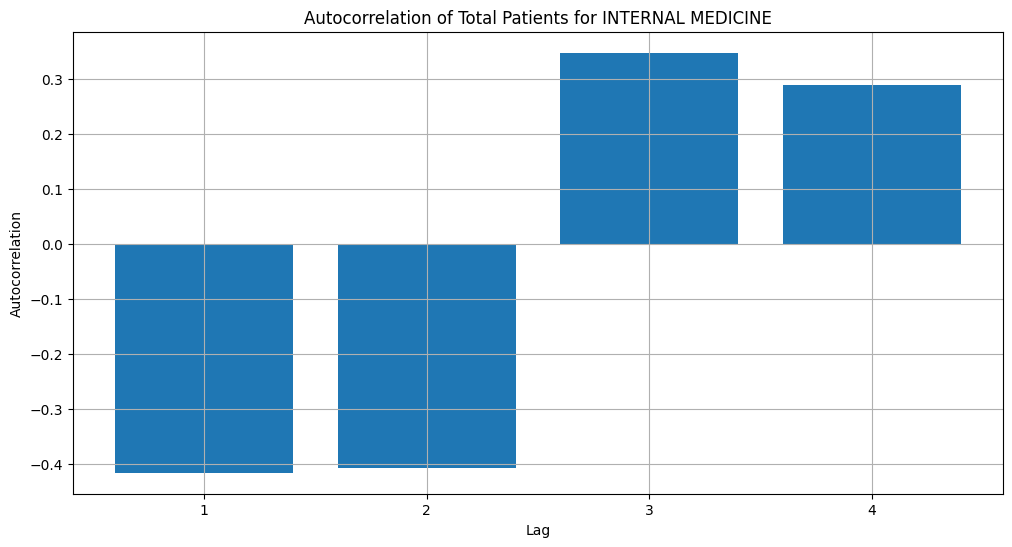

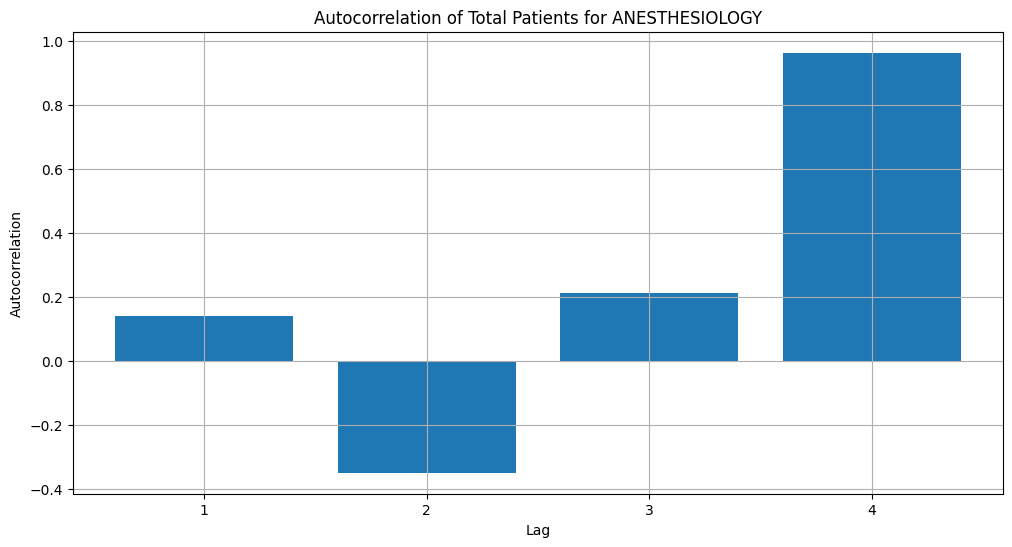

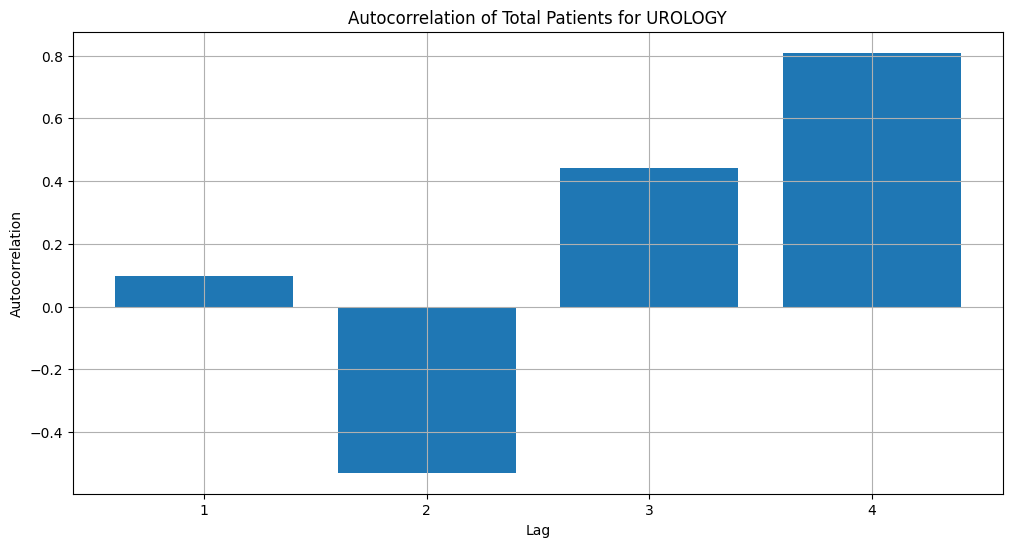

In [23]:
for specialty in filtered_df['specialty'].unique():
    # Filter the DataFrame for the current specialty
    df_specialty = filtered_df[filtered_df['specialty'] == specialty]

    # Group and aggregate
    grouped_df = df_specialty.groupby(['year', 'quarter'])['total_patients'].sum()

    # 4 lags for the four quarters of a year
    lags = 4
    autocorrelations = [grouped_df.autocorr(lag=i) for i in range(1, lags + 1)]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.bar(range(1, lags + 1), autocorrelations)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title(f'Autocorrelation of Total Patients for {specialty}')
    plt.xticks(range(1, lags + 1))
    plt.grid(True)
    plt.show()

# Total Patients

## Anesthesiology

The strong positive autocorrelation at lag 4 would suggest a yearly cycle in the number of patients seen in the Anesthesiology specialty.

## Internal Medicine

The plot suggests there might be a cyclical pattern in the total number of patients for Internal Medicine, particularly noticeable every three periods and annually. 

## Urology

Lag 4 suggests that there may be a seasonal pattern in the patient counts for Urology, potentially reflecting an annual cycle.


In [31]:
import pandas as pd
from statsmodels.stats.diagnostic import acorr_ljungbox

# Aggregate total_claims by year, quarter, and specialty
agg_df = filtered_df.groupby(['year', 'quarter', 'specialty'])['total_claims'].sum().reset_index()

# Now perform Ljung-Box test for each specialty
results = {}
for specialty, group in agg_df.groupby('specialty'):
    # Convert 'year' and 'quarter' to a datetime, which will be at the end of the quarter
    group['time_period'] = pd.to_datetime(group['year'].astype(str) + group['quarter'].astype(str).str.zfill(2) + '01')

    # Ensure the data is sorted by time_period before running the test
    group = group.sort_values('time_period')
    
    # Ljung-Box test 
    lb_results = acorr_ljungbox(group['total_claims'], lags=[1, 2, 3, 4], return_df=True)
    results[specialty] = lb_results

# Results
for specialty, result in results.items():
    print(f"Ljung-Box Test for {specialty}:")
    print(result)
    print("\n")


Ljung-Box Test for ANESTHESIOLOGY:
    lb_stat  lb_pvalue
1  0.113256   0.736467
2  1.693066   0.428899
3  1.788819   0.617371
4  2.987840   0.559862


Ljung-Box Test for INTERNAL MEDICINE:
    lb_stat  lb_pvalue
1  0.479367   0.488709
2  0.949730   0.621969
3  4.887626   0.180213
4  6.739921   0.150287


Ljung-Box Test for UROLOGY:
    lb_stat  lb_pvalue
1  0.338222   0.560857
2  4.537164   0.103459
3  4.568000   0.206304
4  7.697439   0.103312




In [30]:
import pandas as pd
from statsmodels.stats.diagnostic import acorr_ljungbox

# Aggregate total_patients by year, quarter, and specialty
agg_df = filtered_df.groupby(['year', 'quarter', 'specialty'])['total_patients'].sum().reset_index()

# Now perform Ljung-Box test for each specialty
results = {}
for specialty, group in agg_df.groupby('specialty'):
    # Convert 'year' and 'quarter' to a datetime, which will be at the end of the quarter
    group['time_period'] = pd.to_datetime(group['year'].astype(str) + group['quarter'].astype(str).str.zfill(2) + '01')

    # Ensure the data is sorted by time_period before running the test
    group = group.sort_values('time_period')
    
    # Ljung-Box test 
    lb_results = acorr_ljungbox(group['total_patients'], lags=[1, 2, 3, 4], return_df=True)
    results[specialty] = lb_results

# Results
for specialty, result in results.items():
    print(f"Ljung-Box Test for {specialty}:")
    print(result)
    print("\n")


Ljung-Box Test for ANESTHESIOLOGY:
    lb_stat  lb_pvalue
1  0.085914   0.769437
2  0.919387   0.631477
3  0.919389   0.820746
4  1.986427   0.738255


Ljung-Box Test for INTERNAL MEDICINE:
    lb_stat  lb_pvalue
1  1.069167   0.301134
2  2.291244   0.318026
3  3.224418   0.358302
4  3.260216   0.515260


Ljung-Box Test for UROLOGY:
    lb_stat  lb_pvalue
1  0.090863   0.763083
2  1.742435   0.418442
3  1.904151   0.592537
4  2.715220   0.606554




### Total Patients
For all three specialties (Anesthesiology, Internal Medicine, and Urology), the high p-values across all lags indicate a lack of significant autocorrelation in the data. 

### Total Claims
For all three specialties, there is no strong statistical evidence of autocorrelation at the lags tested. While some p-values for Internal Medicine and Urology are close to the significance level, they are not sufficiently low to conclusively reject the null hypothesis.

                                            Specialty  Number of Providers
0                                   INTERNAL MEDICINE                 2775
1                                     FAMILY MEDICINE                  928
2                                          PEDIATRICS                  793
3                              PSYCHIATRY & NEUROLOGY                  488
4                             OBSTETRICS & GYNECOLOGY                  449
5                                           RADIOLOGY                  417
6                                  EMERGENCY MEDICINE                  388
7                                             SURGERY                  347
8                                      ANESTHESIOLOGY                  340
9                                 ORTHOPAEDIC SURGERY                  275
10                                          PATHOLOGY                  178
11                                            UROLOGY                  155
12                       

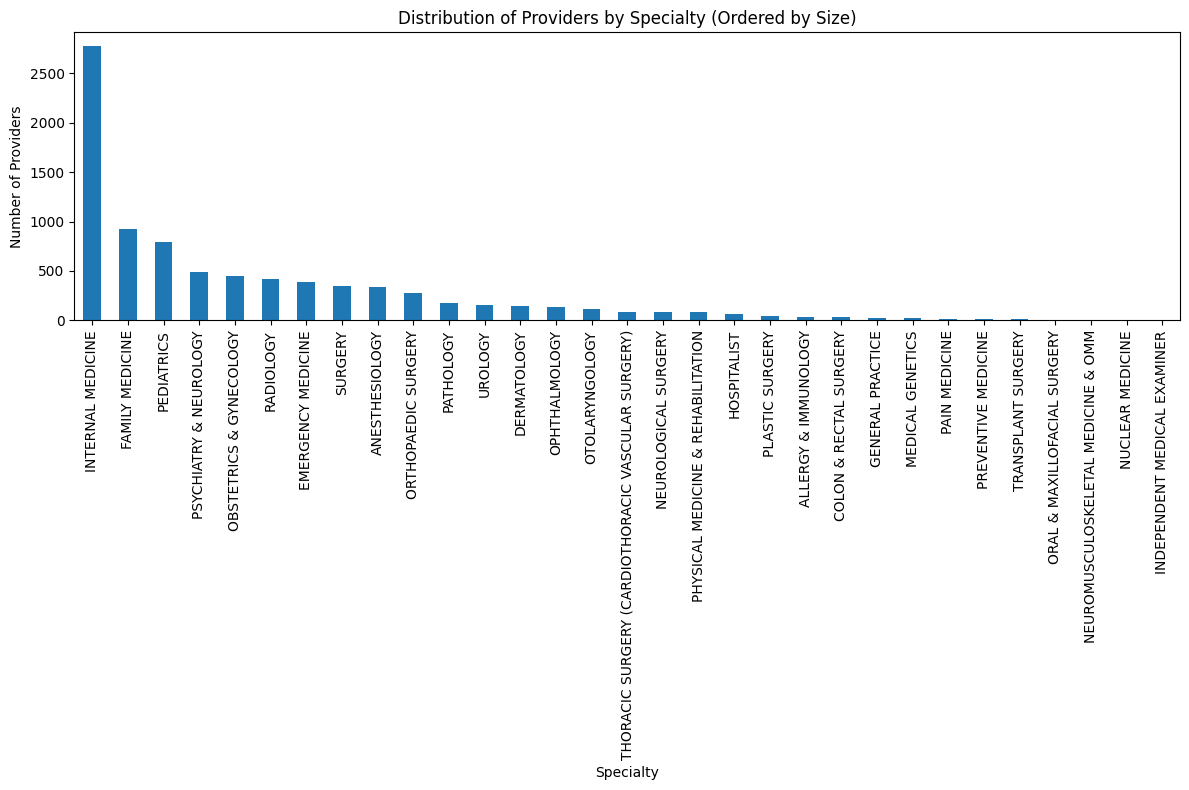

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by 'specialty' and count unique 'clinician_npi'
provider_distribution = joined_df.groupby('specialty')['clinician_npi'].nunique()

# Sort the series in descending order
provider_distribution_sorted = provider_distribution.sort_values(ascending=False)
provider_distribution_df = provider_distribution_sorted.reset_index()
provider_distribution_df.columns = ['Specialty', 'Number of Providers']

# Results
print(provider_distribution_df)

# Plot
plt.figure(figsize=(12, 8))
provider_distribution_sorted.plot(kind='bar')
plt.title('Distribution of Providers by Specialty (Ordered by Size)')
plt.xlabel('Specialty')
plt.ylabel('Number of Providers')
plt.xticks(rotation=90, ha='center')
plt.tight_layout()
plt.show()
